https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview

https://huggingface.co/datasets/t4tiana/store-sales-time-series-forecasting/tree/main

In [6]:
import pandas as pd

train_df = pd.read_csv('store_forecast_dataset/train.csv')
test_df = pd.read_csv('store_forecast_dataset/test.csv')

print("Train Dataset Shape:", train_df.shape)
print("Test Dataset Shape:", test_df.shape)
print("\nColumn names:")
print(train_df.columns.tolist())
print("\nTrain Dataset Info:")
print(train_df.info())

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

print(f"\nTrain date range: {train_df['date'].min()} to {train_df['date'].max()}")
print(f"Test date range: {test_df['date'].min()} to {test_df['date'].max()}")

print("\nFirst few rows of train dataset:")
print(train_df.head())

Train Dataset Shape: (3000888, 6)
Test Dataset Shape: (28512, 5)

Column names:
['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']

Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None

Train date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Test date range: 2017-08-16 00:00:00 to 2017-08-31 00:00:00

First few rows of train dataset:
   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0      

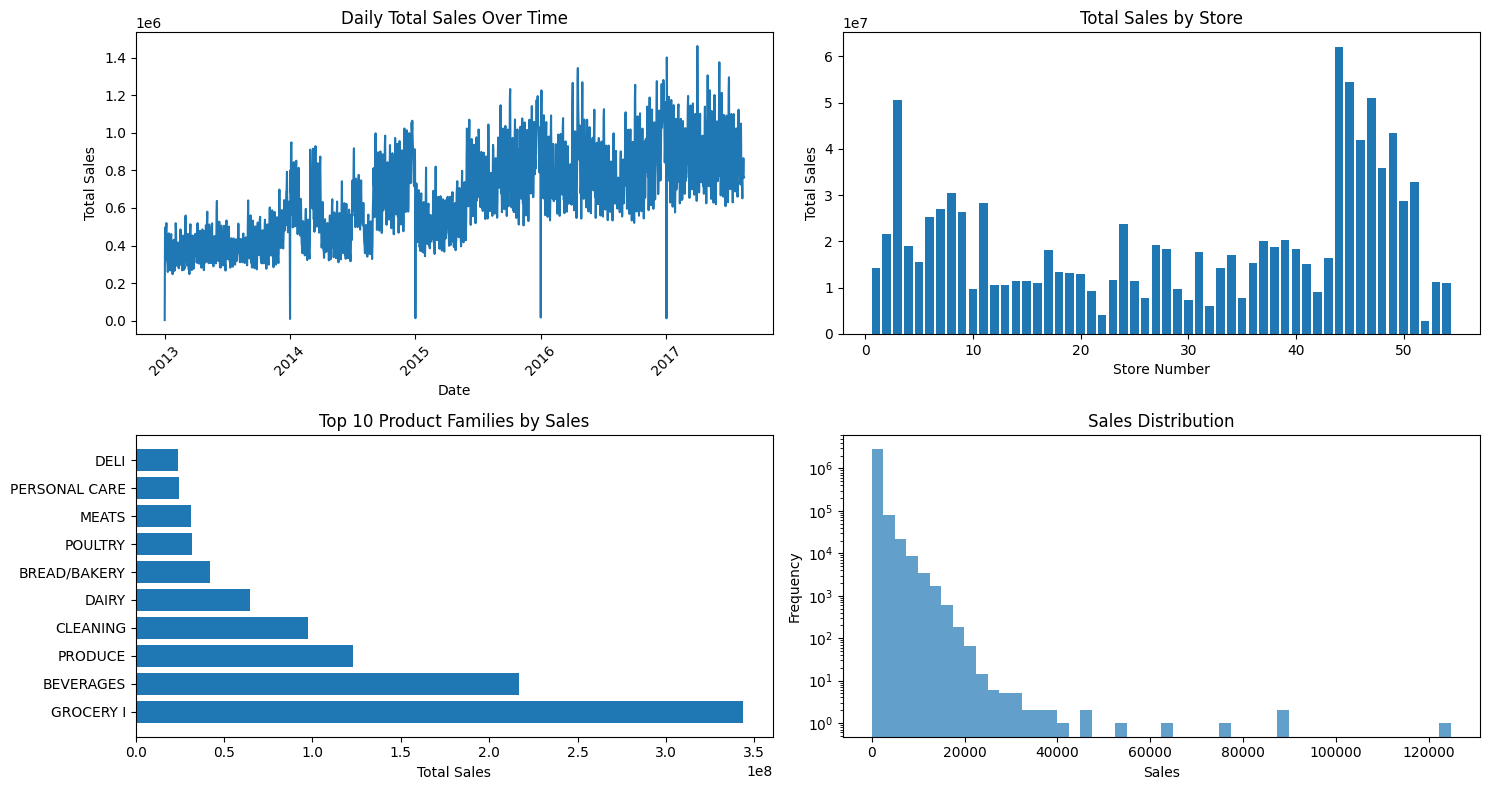

Sales Statistics:
Total Sales: 1,073,644,952.20
Average Daily Sales: 637,556.38
Number of Stores: 54
Number of Product Families: 33


In [10]:
from matplotlib import pyplot as plt

plt.style.use('default')
plt.figure(figsize=(15, 8))

# Aggregate sales by date
daily_sales = train_df.groupby('date')['sales'].sum().reset_index()

plt.subplot(2, 2, 1)
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title('Daily Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)

# Plot sales by store
plt.subplot(2, 2, 2)
store_sales = train_df.groupby('store_nbr')['sales'].sum().reset_index()
plt.bar(store_sales['store_nbr'], store_sales['sales'])
plt.title('Total Sales by Store')
plt.xlabel('Store Number')
plt.ylabel('Total Sales')

# Plot sales by product family
plt.subplot(2, 2, 3)
family_sales = train_df.groupby('family')['sales'].sum().sort_values(ascending=False).head(10)
plt.barh(family_sales.index, family_sales.values)
plt.title('Top 10 Product Families by Sales')
plt.xlabel('Total Sales')

# Plot sales distribution
plt.subplot(2, 2, 4)
plt.hist(train_df['sales'], bins=50, alpha=0.7)
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.yscale('log')

plt.tight_layout()
plt.show()

# Print some basic statistics
print("Sales Statistics:")
print(f"Total Sales: {train_df['sales'].sum():,.2f}")
print(f"Average Daily Sales: {daily_sales['sales'].mean():,.2f}")
print(f"Number of Stores: {train_df['store_nbr'].nunique()}")
print(f"Number of Product Families: {train_df['family'].nunique()}")